## Conditional entropies evaluation
#### Test conditions: 
    a = 0.5
    b = 1/16.0
    A = 2.5
    omega = 2.0
    gamma = 0.1
    period = 2*np.pi/(1.0*omega)
    h = period/32 # time step
    
    new_data = position[::23]

In [1]:
import sys
sys.path.insert(0, 'dcgram_v2')
import save_plot as sp
import numpy as np
sys.path.insert(0, 'dcgram_v2/tests')
from pibic import *
import yaml

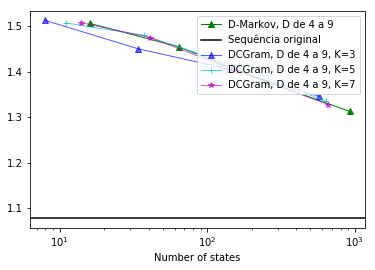

In [2]:
sp.save_plot(parameter='cond_entropies', name='duffing_equation', drange = range(2,6), krange = [3, 5, 7])

## Kolmogorov-Smirnov Tests

In [3]:
with open('../dcgram_files/duffing_equation/results/sequences/dcgram/dcgram_D2_K3.yaml', 'r') as f:
    s_2_3 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/results/machines/dcgram/dcgram_D2_K3.yaml', 'r') as f:
    m_2_3 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/results/sequences/dcgram/dcgram_D3_K3.yaml', 'r') as f:
    s_3_3 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/results/machines/dcgram/dcgram_D3_K3.yaml', 'r') as f:
    m_3_3 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/results/sequences/dmarkov/dmark_D2.yaml', 'r') as f:
    s_2 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/results/machines/dmarkov/dmark_D2.yaml', 'r') as f:
    m_2 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation/original/original_len_1391305.yaml', 'r') as f:
    s = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta010/original/original_len_13914.yaml', 'r') as f:
    s_beta_010 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta012/original/original_len_13914.yaml', 'r') as f:
    s_beta_012 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta014/original/original_len_13914.yaml', 'r') as f:
    s_beta_014 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta020/original/original_len_13914.yaml', 'r') as f:
    s_beta_020 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta022/original/original_len_13914.yaml', 'r') as f:
    s_beta_022 = yaml.load(f)
    
with open('../dcgram_files/duffing_equation_beta030/original/original_len_13914.yaml', 'r') as f:
    s_beta_030 = yaml.load(f)

In [22]:
v1 = calc_mean_vector(m_3_3, s, 1000, rep = 1000)[0]
v10 = sa.calc_occup_vector(m_3_3, s_beta_010, 1000)
v12 = sa.calc_occup_vector(m_3_3, s_beta_012, 1000)
v14 = sa.calc_occup_vector(m_3_3, s_beta_014, 1000)
v20 = sa.calc_occup_vector(m_3_3, s_beta_020, 1000)
v22 = sa.calc_occup_vector(m_3_3, s_beta_022, 1000)
v30 = sa.calc_occup_vector(m_3_3, s_beta_030, 1000)

In [23]:
stat, p_val = ks_2samp(v1, v10)
print(f'stat: {stat}, prob: {p_val}')
stat, p_val = ks_2samp(v1, v12)
print(f'stat: {stat}, prob: {p_val}')
stat, p_val = ks_2samp(v1, v14)
print(f'stat: {stat}, prob: {p_val}')
stat, p_val = ks_2samp(v1, v20)
print(f'stat: {stat}, prob: {p_val}')
stat, p_val = ks_2samp(v1, v22)
print(f'stat: {stat}, prob: {p_val}')
stat, p_val = ks_2samp(v1, v30)
print(f'stat: {stat}, prob: {p_val}')

stat: 0.08823529411764708, prob: 0.998882594033865
stat: 0.1470588235294118, prob: 0.825315708763453
stat: 0.08823529411764705, prob: 0.998882594033865
stat: 0.1764705882352941, prob: 0.6212924269882373
stat: 0.17647058823529413, prob: 0.6212924269882372
stat: 0.2941176470588235, prob: 0.08534160666282316


In [12]:
print(v1)
print(v10)

[0.050163 0.076514 0.014545 0.055066 0.041377 0.014115 0.038557 0.035958
 0.020316 0.017409 0.0381   0.035879 0.014448 0.014303 0.076812 0.055729
 0.020385 0.049916 0.041094 0.017055 0.004597 0.008707 0.042784 0.042476
 0.029211 0.023263 0.023198 0.00472  0.029158 0.025914 0.008741 0.025909
 0.001813 0.001768]
[0.0070914  0.01105775 0.00215411 0.0072521  0.00559011 0.001986
 0.00527199 0.00544635 0.00279317 0.00250317 0.00515635 0.00520575
 0.00192129 0.00207317 0.01109398 0.00785269 0.00294223 0.0069414
 0.00576858 0.00239788 0.0006547  0.00113565 0.0061167  0.0057914
 0.0042354  0.00304788 0.00316352 0.00070376 0.0039907  0.00352411
 0.00114847 0.00359164 0.00021376 0.00018282]
